# 00. Imports

In [1]:
%load_ext autoreload
%autoreload 2
%run nnn/ipynb_init.py
%matplotlib inline
import nupack
from sklearn.model_selection import train_test_split

# 01. Data preparation

## 01.1 Basic filtering

QC filtering and removing control constructs that do not have hairpin melting behaviors.

Clean up data for model training.

### 01.1.1 Making **arr_v1**

With (relaxed) 2-state filter & variant-level Tm filter.

**Input:**

- `./data/nnnlib2b_replicates.tsv`

- `./data/annotation/NNNlib2b_annotation_2024_duplicates_dropped.tsv`



In [2]:
annotation_file = './data/annotation/NNNlib2b_annotation_2024_duplicates_dropped.tsv'
annotation = fileio.read_annotation(annotation_file, sodium=0.075)
replicate_df = pd.read_table('./data/nnnlib2b_replicates.tsv')

print('\nReading Array Melt replicate data...\n')
arraydata = ArrayData(replicate_df=replicate_df.iloc[:4,:],
                    annotation_file=annotation_file)

print('\n\nFiltering two state variants...\n')
myfilter = "dH_err_rel < 0.5 & Tm_err_abs < 10 & redchi < 2 & n_inlier > 8"
pass_df = arraydata.filter_two_state(min_rep_pass=1, force_recalculate=False, overwrite_dH=False, 
                                     inplace=True, myfilter=myfilter, plot_fig=False)

print('\n\nRemoving extra control series...\n')
arr = arraydata.data.join(arraydata.annotation)
excluded_construct_type = ['pseudoknot_pt_muts', 'PolyNTControls', 'RepeatControls', 'StemDangle_3p', 'StemDangle_53p', 'StemDangle_5p', 'PUMcontrols']
arr = arr[arr.reset_index().ConstructType.apply(lambda s: s not in excluded_construct_type).values]
# Remove pseudoknots without annotation
arr = arr.dropna(subset=['ConstructType', 'RefSeq','TargetStruct'])
print('%d variants left.' % arr.shape[0])

print('\n\nFiltering Tm in range...\n')
variant_filter = 'Tm < 60 & Tm > 0'
arr_in_range = arr.query(variant_filter)
print('%d/%d (%.2f%%) variants met the Tm in range criterion.' % 
        (len(arr_in_range), len(arr), len(arr_in_range)/len(arr)*100))
arr = arr_in_range

arr.to_csv(os.path.join('./data/models/raw', 'arr_v1_n=%d.csv' % arr.shape[0]))


Reading Array Melt replicate data...

86.43% variants passed the filter n_clusters > 5 & dG_37_se < 2 & Tm_se < 25 & dH_se < 25 & RMSE < 0.5
78.88% variants passed the filter n_clusters > 5 & dG_37_se < 2 & Tm_se < 25 & dH_se < 25 & RMSE < 0.5
64.31% variants passed the filter n_clusters > 5 & dG_37_se < 2 & Tm_se < 25 & dH_se < 25 & RMSE < 0.5
71.46% variants passed the filter n_clusters > 5 & dG_37_se < 2 & Tm_se < 25 & dH_se < 25 & RMSE < 0.5


Filtering two state variants...

86.43% variants passed the filter n_clusters > 5 & dG_37_se < 2 & Tm_se < 25 & dH_se < 25 & RMSE < 0.5
78.88% variants passed the filter n_clusters > 5 & dG_37_se < 2 & Tm_se < 25 & dH_se < 25 & RMSE < 0.5
64.31% variants passed the filter n_clusters > 5 & dG_37_se < 2 & Tm_se < 25 & dH_se < 25 & RMSE < 0.5
71.46% variants passed the filter n_clusters > 5 & dG_37_se < 2 & Tm_se < 25 & dH_se < 25 & RMSE < 0.5

30091/31000 (97.07%) variants passed the two state criteria.


Removing extra control series...

2986

### 01.1.2 Show variant counts

- Show variant class accounting information:

In [3]:
arraydata.accounting_df.T

,designed,fitted,passed2state
Bulges,11520,9474,9408
Control,595,127,112
External,31,20,20
MisMatches,18240,11366,11086
TETRAloop,6144,5749,5465
TRIloop,1536,1454,1402
VARloop,172,7,5
WatsonCrick,3072,2680,2479


- Show number of variants in each subclass (construct type)

In [4]:
ctype, counts = np.unique(arr_in_range.ConstructType, return_counts=True)
dict(zip(ctype, counts))

{'3mer': 1890,
 'AC_mismatch_varpos': 2649,
 'BaeControls': 17,
 'Centered': 2691,
 'GT_mismatch_varpos': 3495,
 'NN': 975,
 'NNN': 4884,
 'NNN_3primebulge': 4260,
 'NNN_5prime_bulge': 4233,
 'NN_3primebulge': 304,
 'NN_5primebulge': 300,
 'VARloop': 5,
 'WBcontrols': 1,
 'WC_5ntstem': 760,
 'WC_6ntstem': 682,
 'WC_7ntstem': 585}

## 01.2 Adjust offset

Use UV melting data to adjust systematic offset.

In [5]:
# Reload data from the previous 01.1 basic filtering step
arr = pd.read_csv('./data/models/raw/arr_v1_n=27732.csv', index_col=0)


297 / 387 single curves passed QC




(-4.0, 0.0)

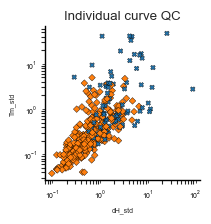

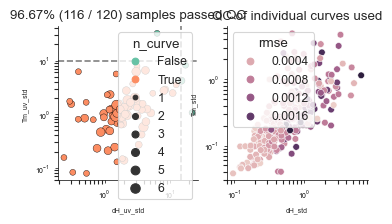

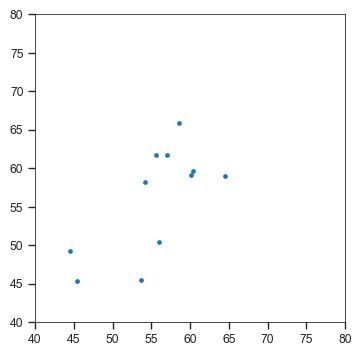

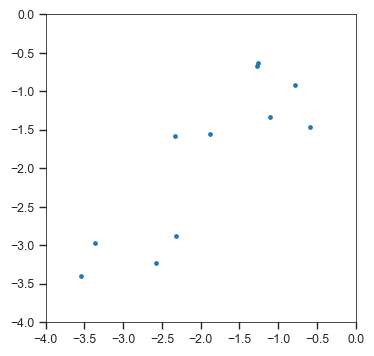

In [6]:
"""
Get the offset from UV melting data
"""
# copy pasted from ECL command center for convenience
# only one peak found by HPLC AnalyzePeaks
hplc_clean_seqid = ["WC68_stem_3p", "WC68_stem_5p", "WC1025_split_5p", \
"WC1025_split_3p", "WC1375_stem_5p", "WC1375_stem_3p", "DMM004_5p", \
"DMM004_3p", "DMM005_5p", "DMM005_3p", "DMM006_5p", "DMM007_5p", \
"DMM007_3p", "BC0", "BC1", "BC6", "BC7", "BC8", "BC9", "BC10", \
"BC11", "MMCNNN2328", "MMCNNN2331", "MMCNNN2334", "MMCNNN2335", \
"MMCNNN2336", "MMCNNN2337", "MMTM1325", "MMTM176", "MMTM178", \
"MMTM179", "MMTM181", "MMTM185", "MMTM189", "MMTM1917", "MMTM29", \
"MMTM397", "MMTM509", "MMTM877", "DMM003_3p_rc", "DMM004_3p_rc", \
"DMM005_3p_rc", "DMM006_3p_rc", "DMM007_3p_rc", "TETNN1003", \
"TETNN999", "TETNN963", "TETNN979", "TETNNN1696", "TETNNN2082", \
"TETNNN1570", "HP002", "HP003", "HP004", "HP005", "HP007", "HP008", \
"HP010", "HP011", "HP012", "HP014", "HP015", "HP016", "HP017", \
"HP018", "HP019", "HP021", "HP022", "HP023", "HP024"]

sample_sheet_file = './data/uv_melt/ECLTables/ECLSampleSheet.csv'
datadir="./data/uv_melt/ECLExportAuto"
result_file='./data/uv_melt/uvmelt_single.csv'
agg_result_file='./data/uv_melt/uvmelt_agg.csv'

result_df = pd.read_csv(result_file, index_col=0)
result_agg_df = uv.agg_fit_result(uvmelt_result_file=result_file,
                               agg_result_file=agg_result_file,
                               single_curve_qc_criteria='rmse < 0.002 & dH_std < 10 & Tm_std < 5 & dH < 0 & dH > -100 & Tm > 0 & Tm < 120',
                               Tm_std_thresh=10, dH_std_thresh=15,
                               sample_sheet_file=sample_sheet_file, 
                               clean=True, only_use_cooling=False)

result_agg_df = result_agg_df[result_agg_df.SEQID.isin(hplc_clean_seqid)]

# Only use data measured in the same melting buffer as Array Melt
# Note that Na_mM = 25 in UV melting data files means the concentration of NaCl is 25 mM,
# not including the Na+ from Na-HEPES
vf = result_agg_df.query('is_hairpin & Na_mM == 25').sort_values(by=['conc_uM', 'n_curve', 'curve_date']).drop_duplicates(keep='last').merge(arr, how='left', on='SEQID')

df_q = vf.dropna(subset=['Tm', 'dG_37'])
df_q.dG_37_uv_std = 0

dTm = np.median(df_q.Tm_uv - df_q.Tm)
df_q['Tm_adj'] = df_q.Tm + dTm
df_q['dG_37_adj'] = util.get_dG(dH=df_q.dH, Tm=df_q.Tm_adj, celsius=37)

plt.figure(figsize=(4,4))
plt.plot(df_q.Tm_uv, df_q.Tm_adj, '.')
lim = [40,80]
plt.xlim(lim)
plt.ylim(lim)

plt.figure(figsize=(4,4))
plt.plot(df_q.dG_37_uv, df_q.dG_37_adj, '.')
lim = [-4,0]
plt.xlim(lim)
plt.ylim(lim)

In [7]:
def adjust_offset(dH, Tm, dTm):
    Tm_adj = Tm + dTm
    dG_37_adj = util.get_dG(dH=dH, Tm=Tm_adj, celsius=37)
    dS_adj = dH / (Tm_adj + 273.15)
    return dict(dH=dH, dS=dS_adj, Tm=Tm_adj, dG_37=dG_37_adj)

cols = ['dH_se', 'Tm_se', 'dG_37_se', 'dS_se', 'RefSeq', 'TargetStruct', 'Series']
arr_adj = pd.DataFrame(adjust_offset(arr.dH, arr.Tm, dTm))
arr_adj[cols] = arr[cols]

fn = os.path.join('./data/models/processed', 'arr_v1_adjusted_n=%d.csv' % arr_adj.shape[0])
arr_adj.to_csv(fn)
print('Saved to `%s`\n\n' % fn)
print('The offset ∆Tm = %.2f °C' % dTm)

dG_median = util.get_dG(dH=np.median(arr.dH), Tm=np.median(arr.Tm), celsius=37)
dG_adj_median = util.get_dG(dH=np.median(arr.dH), Tm=np.median(arr.Tm) + dTm, celsius=37)
print('Median of ∆G changed from %.2f -> %.2f kcal/mol,\nand ∆∆G = %.2f kcal/mol.' % (dG_median, dG_adj_median, dG_adj_median - dG_median))

Saved to `./data/models/processed/arr_v1_adjusted_n=27732.csv`


The offset ∆Tm = 8.64 °C
Median of ∆G changed from -0.20 -> -0.86 kcal/mol,
and ∆∆G = -0.66 kcal/mol.


## 01.3 Salt correct to 1M sodium

Correct Array Melt data to 1M sodium for model training, especially the NUPACK-compatible *dna24* model,
as the model parameters are in 1M.

Data files:
    `arr_adj` -> `arr_1M`

In [8]:
%%time
param_names = ['dH','dS','Tm', 'dG_37']
arr_1M = pd.DataFrame(index=arr_adj.index, columns=param_names)

for i, row in arr_adj.iterrows():
    param_name_dict = util.get_Na_adjusted_param(Na=1.0, from_Na=0.075, dH=row.dH, Tm=row.Tm, seq=row.RefSeq)
    arr_1M.loc[i,:] = param_name_dict

arr_1M[cols] = arr[cols]

fn = './data/models/processed/arr_v1_1M_75mM_n=%d.csv'%arr_1M.shape[0]
arr_1M.to_csv(fn)
print('Saved to `%s`' % fn)

Saved to `./data/models/processed/arr_v1_1M_75mM_n=27732.csv`
CPU times: user 5.52 s, sys: 51.8 ms, total: 5.57 s
Wall time: 5.54 s


## 01.4 Update train-val-test split

In [9]:
agg_result_file='./data/uv_melt/uvmelt_agg.csv'
uv_df = pd.read_csv(agg_result_file, index_col=1)
arr_1M = pd.read_csv('./data/models/processed/arr_v1_1M_n=27730.csv', index_col=0)
arr_p_unfold = pd.read_csv('./data/models/raw/arr_p_unfold_n=31000.csv', index_col=0)


In [10]:
from sklearn.model_selection import train_test_split

ind2split = arr_1M.index#list(set(arr_1M.index) - set(uv_df.index))
series2split = arr_1M.loc[ind2split, 'Series']

# Split indices (without the UV-measured variants)
train_val_ind, test_ind = train_test_split(ind2split, test_size=.05,
                                       random_state=42, stratify=series2split)
train_ind, val_ind = train_test_split(arr_1M.loc[train_val_ind,:].index, test_size=.05,
                                      random_state=43, stratify=arr_1M.loc[train_val_ind,:].Series)

n_train, n_val, n_test = len(train_ind), len(val_ind), len(test_ind)
print('#variants in each group:')
print('train','val ','test')
print(n_train, n_val, n_test)

split_dict = dict(train_ind=train_ind.tolist(),
                  val_ind=val_ind.tolist(),
                  test_ind=test_ind.tolist())
with open('./data/models/raw/data_split.json', 'w') as fh:
    json.dump(split_dict, fh, indent=4)
print('\n\nSaved to `data_split.json`')

#variants in each group:
train val  test
25025 1318 1387


Saved to `data_split.json`


## 01.5 External data preparation

### 01.5.1 Orthogonal ECL UV meltinng hairpins

These hairpins were orthogonally designed and not in the Array Melt library.

In [11]:
"""
ECL UV melting data cleaning
Reduced to HP only as the reset are already in the array dataset.
"""
from nnn import train_nn as tnn

mydata = tnn.MyData()
mydata.load_everything()

In [12]:
uv_agg_df = fileio.clean_uv_df(mydata.uv_df, mydata.ecl_oligo_df, mydata.annotation)
uv_agg_df = uv_agg_df.reset_index(names=['SEQID'])
uv_agg_df = uv_agg_df.loc[uv_agg_df.SEQID.apply(lambda x: x.startswith('HP'))]
uv_agg_df = uv_agg_df.set_index('SEQID')
fn = './data/models/raw/uv_n=%d.csv'%len(uv_agg_df)
uv_agg_df.to_csv(fn)
print('Saved to `%s`' % fn)

val_ind, test_ind = train_test_split(np.unique(uv_agg_df.index), test_size=.5,
                                       random_state=42)

print('val ','test')
print(len(uv_agg_df.loc[val_ind]), len(uv_agg_df.loc[test_ind]))

split_dict = dict(
    train_ind=[],
    val_ind=val_ind.tolist(),
    test_ind=test_ind.tolist())
fileio.write_json(split_dict, './data/models/raw/data_split_uv.json')

Saved to `./data/models/raw/uv_n=19.csv`
val  test
10 9


### 01.5.2 SantaLucia mismatch parameters

In [13]:
# Format SantaLucia mismatch parameters
sl_mm = pd.read_csv('./data/literature/SantaLucia_single_mismatch.csv', index_col=0)
sl_mm['isWC'] = sl_mm.dG_37.apply(lambda x: x == 'WC')
sl_wc = pd.read_csv('./data/literature/SantaLucia_full.tsv', sep='\t', index_col=0)

def add_wc(row):
    if row.dG_37 == 'WC':
        return float(sl_wc.loc[row.name, 'dG_37'])
    else:
        return float(row.dG_37)
    
sl_mm['dG_37'] = sl_mm.apply(add_wc, axis=1)
sl_mm.to_csv('./data/literature/SantaLucia_mm_wc.csv')

### 01.5.3 Oliveira et al. (ov)

In [14]:
"""
Oliveira data split (OV)
"""
center_df = fileio.read_Oliveira_df('./data/literature/Oliveira_2020_mismatches.csv')

val_ind, test_ind = train_test_split(center_df.index, test_size=.5,
                                       random_state=42)

n_val, n_test = len(val_ind), len(test_ind)
print('val ','test')
print(n_val, n_test)

split_dict = dict(train_ind=[],
                  val_ind=val_ind.tolist(),
                  test_ind=test_ind.tolist())

with open('./data/models/raw/data_split_Oliveira.json', 'w') as fh:
    json.dump(split_dict, fh, indent=4)

val  test
1387 1388


### 01.5.4 Literature UV melting duplexes (lit_uv)

In [15]:
"""
348oligos data split (DP) (lit_uv)
train:val:test = 0:1:1
"""
uv_df = pd.read_csv('./data/literature/compiled_DNA_Tm_348oligos.csv', index_col=0)

val_ind, test_ind = train_test_split(uv_df.index, test_size=.5,
                                       random_state=42)
train_ind = []
n_train, n_val, n_test = len(train_ind), len(val_ind), len(test_ind)
print('train', 'val ','test')
print(n_train, n_val, n_test)

split_dict = dict(
    train_ind=train_ind,
    val_ind=val_ind.tolist(),
    test_ind=test_ind.tolist())

with open('./data/models/raw/data_split_348oligos.json', 'w') as fh:
    json.dump(split_dict, fh, indent=4)

train val  test
0 174 174


# 02. Dataset combination

In [16]:
val_df, combined_split_dict = fileio.read_val_df('all')
val_df.to_csv('./data/models/raw/combined_dataset.csv')
fileio.write_json(combined_split_dict, './data/models/raw/combined_data_split.json')
print('#variants in train, val, test')
print([len(inds) for inds in combined_split_dict.values()])

#variants in train, val, test
[25025, 2888, 2958]


In [17]:
# Test the combined data file
df = fileio.load_val_df('./data/models/raw/combined_dataset.csv')

### SOME TESTS ###
# An index test
# Make sure it has variants from all datasets
for test_id in ['DP347', 'WC999', 'varloop257621', 'OV2679']:
    ind = np.searchsorted(df.index, [test_id])
    assert df.iloc[ind[0],:].name == test_id
    
### Save back ###
df.fillna(0, inplace=True)
df.to_csv('./data/models/raw/combined_dataset.csv')